<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-17 08:45:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100%  114K=0.2s

2020-08-17 08:45:23 (114 KB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

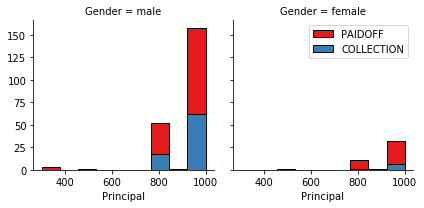

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

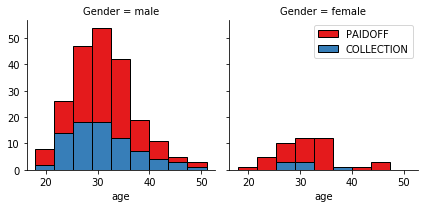

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

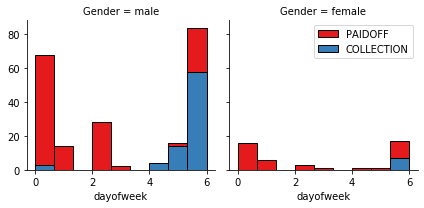

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              1              0.750000
                      0              0.250000
High School or Below  1              0.741722
                      0              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               1              0.765101
                      0              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

### Train Test Split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will 

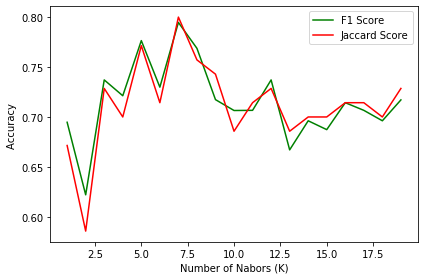

In [21]:
#from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

from sklearn.neighbors import KNeighborsClassifier

Ks = 20
#mean_acc = np.zeros((Ks-1))
#std_acc = np.zeros((Ks-1))
f1_knn = np.zeros((Ks-1))
jaccard_knn = np.zeros((Ks-1))

for n in range(1,Ks):    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn =neigh.predict(X_test)
    f1_knn[n-1] = f1_score(y_test, yhat_knn, average='weighted')
    jaccard_knn[n-1] = jaccard_similarity_score(y_test, yhat_knn)
    #mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    #std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

# mean_acc
plt.plot(range(1,Ks),f1_knn,'g')
plt.plot(range(1,Ks),jaccard_knn,'r')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('F1 Score ', 'Jaccard Score'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [22]:
print( "The best F1 Score was ", f1_knn.max(), "with k=", f1_knn.argmax()+1) 
print( "The best Jaccard Score was ", jaccard_knn.max(), "with k=", jaccard_knn.argmax()+1) 

The best F1 Score was  0.7946428571428571 with k= 7
The best Jaccard Score was  0.8 with k= 7


In [23]:
k = f1_knn.argmax()+1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X, y)

# Decision Tree

C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will 

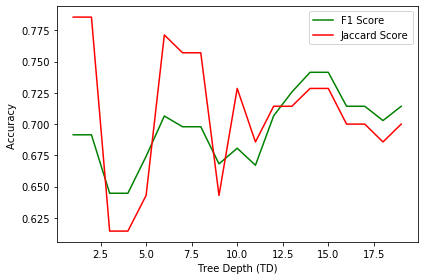

In [24]:
from sklearn.tree import DecisionTreeClassifier
#loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
#loanTree.fit(X_train,y_train)
#predTree = loanTree.predict(X_test)
#print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))


TDs = 20
f1_tree = np.zeros((TDs-1))
jaccard_tree = np.zeros((TDs-1))

for n in range(1,TDs) :
    #Train Model and Predict  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    predTree = loanTree.predict(X_test)

    f1_tree[n-1] = f1_score(y_test, predTree, average='weighted')
    jaccard_tree[n-1] = jaccard_similarity_score(y_test, predTree)

plt.plot(range(1,TDs),f1_tree,'g')
plt.plot(range(1,Ks),jaccard_tree,'r')
plt.legend(('F1 Score ', 'Jaccard Score'))
plt.ylabel('Accuracy ')
plt.xlabel('Tree Depth (TD)')
plt.tight_layout()
plt.show()

In [25]:
print( "The best F1 Score was ", f1_tree.max(), "with Depth=", f1_tree.argmax()+1) 
print( "The best Jaccard Score was ", jaccard_tree.max(), "with Depth=", jaccard_tree.argmax()+1) 

The best F1 Score was  0.7414965986394557 with Depth= 14
The best Jaccard Score was  0.7857142857142857 with Depth= 1


In [26]:
TD = f1_tree.argmax()+1
#TD = 6
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = TD).fit(X,y)

In [27]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [28]:
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

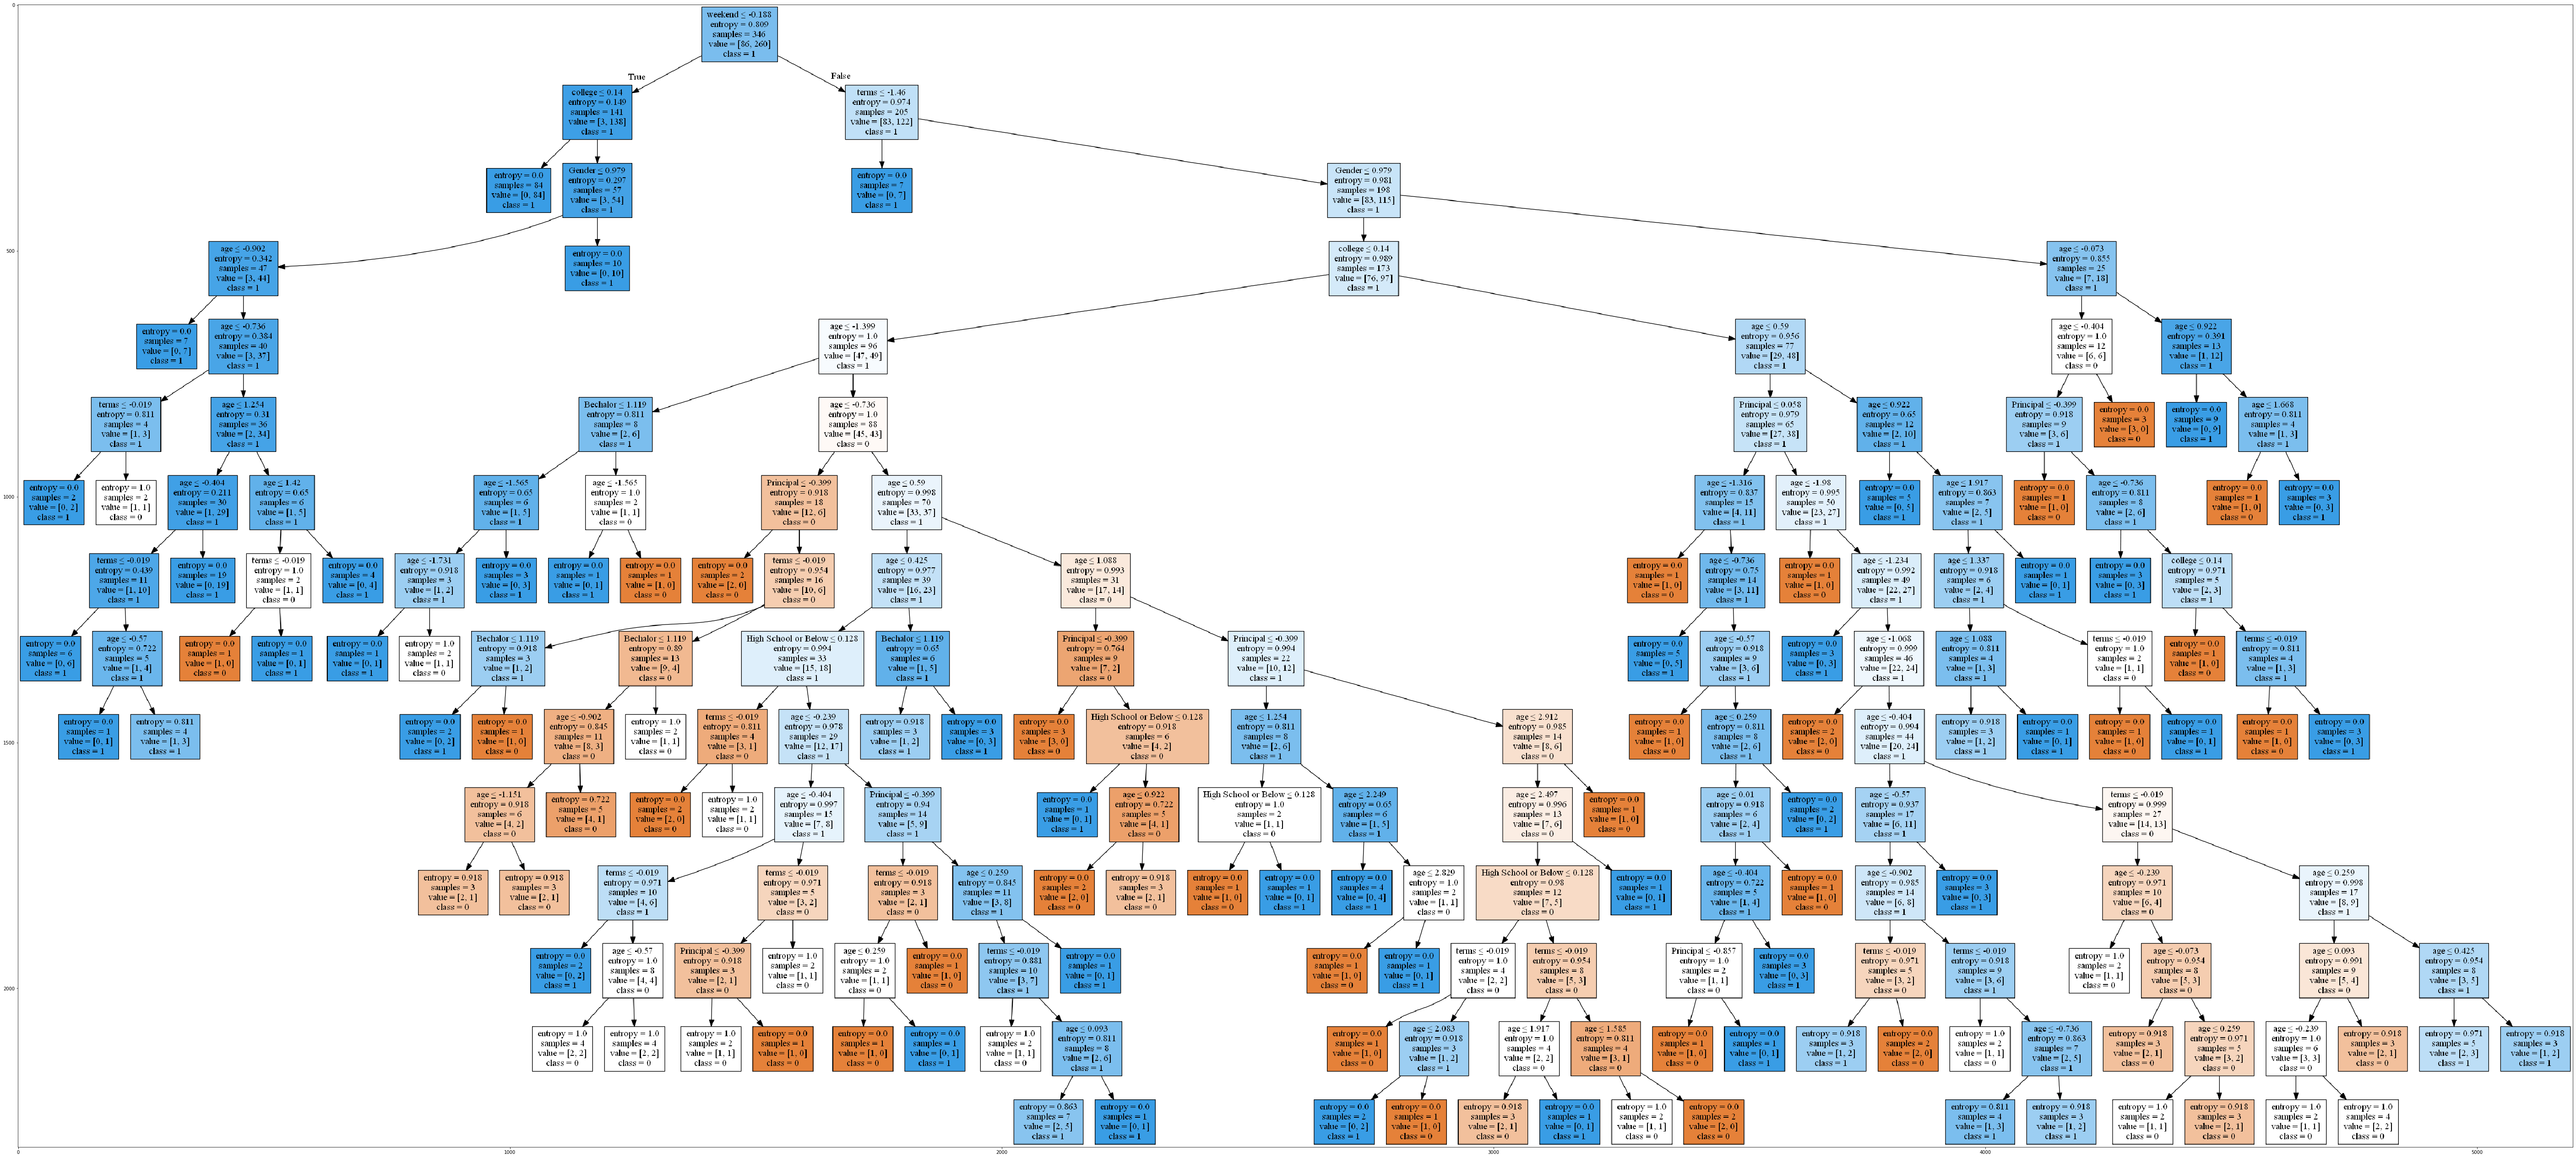

In [29]:
dot_data = StringIO()
filename = "loan.png"
featureNames = Feature.columns
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names=np.unique(y_train).astype(str) , filled=True,special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will 

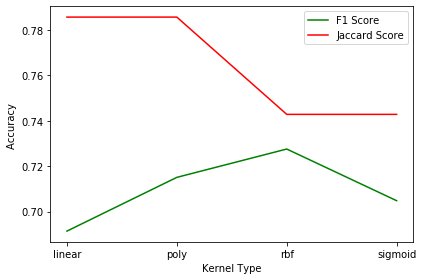

In [30]:
from sklearn import svm

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
f1_svm = np.zeros((len(kernel)))
jaccard_svm = np.zeros((len(kernel)))

for n in range(0,len(kernel)) :
    clf = svm.SVC(kernel=kernel[n])
    clf.fit(X_train, y_train)
    yhat_svm = clf.predict(X_test)
    f1_svm[n] = f1_score(y_test, yhat_svm, average='weighted')
    jaccard_svm[n] = jaccard_similarity_score(y_test, yhat_svm)

plt.plot(kernel,f1_svm,'g')
plt.plot(kernel,jaccard_svm,'r')
plt.legend(('F1 Score ', 'Jaccard Score'))
plt.ylabel('Accuracy ')
plt.xlabel('Kernel Type')
plt.tight_layout()
plt.show()
#clf = svm.SVC(kernel='rbf')
#clf.fit(X_train, y_train)
#yhat = clf.predict(X_test)
#yhat [0:5]

In [31]:
print( "The best F1 Score was ", f1_svm.max(), "with Kernel= ", kernel[f1_svm.argmax()]) 
print( "The best Jaccard Score was ", jaccard_svm.max(), "with Kernel= ", kernel[jaccard_svm.argmax()]) 

The best F1 Score was  0.7275882012724117 with Kernel=  rbf
The best Jaccard Score was  0.7857142857142857 with Kernel=  linear


In [32]:
clf = svm.SVC(kernel=kernel[f1_svm.argmax()])
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Logistic Regression

C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will 

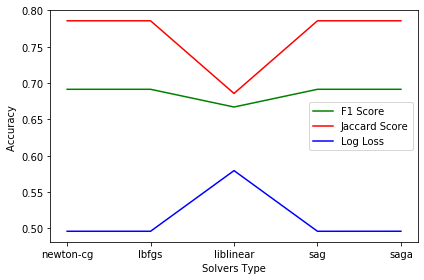

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

f1_log = np.zeros((len(solvers)))
jaccard_log = np.zeros((len(solvers)))
loss_log = np.zeros((len(solvers)))

for n in range(0,len(solvers)) :
    LR = LogisticRegression(C=0.01, solver=solvers[n]).fit(X_train,y_train)
    yhat_log = LR.predict(X_test)
    yhat_log_prob = LR.predict_proba(X_test)
    
    f1_log[n] = f1_score(y_test, yhat_log, average='weighted')
    jaccard_log[n] = jaccard_similarity_score(y_test, yhat_log)
    loss_log[n] = log_loss(y_test, yhat_log_prob)

plt.plot(solvers,f1_log,'g')
plt.plot(solvers,jaccard_log,'r')
plt.plot(solvers,loss_log,'b')
plt.legend(('F1 Score ', 'Jaccard Score', 'Log Loss'))
plt.ylabel('Accuracy ')
plt.xlabel('Solvers Type')
plt.tight_layout()
plt.show()

In [34]:
print( "The best F1 Score was ", f1_log.max(), "with Solver= ", solvers[f1_log.argmax()]) 
print( "The best Jaccard Score was ", jaccard_log.max(), "with Solver= ", solvers[jaccard_log.argmax()]) 
print( "The best Log Loss was ", loss_log.min(), "with Solver= ", solvers[loss_log.argmin()]) 

The best F1 Score was  0.6914285714285714 with Solver=  newton-cg
The best Jaccard Score was  0.7857142857142857 with Solver=  newton-cg
The best Log Loss was  0.49602588294248845 with Solver=  sag


In [35]:
LR = LogisticRegression(C=0.01, solver=solvers[f1_log.argmax()]).fit(X,y)

# Model Evaluation using Test set

In [36]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-17 08:45:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 9.07M=0s

2020-08-17 08:45:48 (9.07 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [38]:
test_df = pd.read_csv('loan_test.csv')
#test_df.head()
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
#test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)
#test_df.drop(['Master or Above'], axis = 1,inplace=True)
#test_df.head()
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
#test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
#test_Feature.head()
test_X = test_Feature
test_y = test_df['loan_status'].values
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)

In [39]:
#KNN
knn_yhat=neigh.predict(test_X)
knn_f1 = f1_score(test_y, knn_yhat, average='weighted')
knn_jaccard = jaccard_similarity_score(test_y, knn_yhat)

print("KNN F1 Score = ",  knn_f1)

print("KNN Jaccard Score = ", knn_jaccard)

KNN F1 Score =  0.7144311330357843
KNN Jaccard Score =  0.7407407407407407
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [40]:
#Decision Tree
tree_yhat = loanTree.predict(test_X)
tree_f1 = f1_score(test_y, tree_yhat, average='weighted')
tree_jaccard = jaccard_similarity_score(test_y, tree_yhat)

print("Decision Tree F1 Score = ", tree_f1 )

print("Decision Tree Jaccard Score = ", tree_jaccard)

Decision Tree F1 Score =  0.6886205279919816
Decision Tree Jaccard Score =  0.6851851851851852
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [41]:
#SVM
svm_yhat = clf.predict(test_X)
svm_f1 = f1_score(test_y, svm_yhat, average='weighted')
svm_jaccard = jaccard_similarity_score(test_y, svm_yhat)

print("SVM F1 Score = ", svm_f1 )

print("SVM Jaccard Score = ", svm_jaccard)

SVM F1 Score =  0.6212664277180406
SVM Jaccard Score =  0.7222222222222222
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [42]:
# Log Regression
log_yhat = LR.predict(test_X)
log_yhat_prob = LR.predict_proba(test_X)

log_f1 = f1_score(test_y, log_yhat, average='weighted')
log_jaccard = jaccard_similarity_score(test_y, log_yhat)
log_loss = log_loss(test_y, log_yhat_prob)

print("Log F1 Score = ",  log_f1)
print("Log Jaccard Score = ", log_jaccard)
print("Log Loss = ", log_loss)

Log F1 Score =  0.6304176516942475
Log Jaccard Score =  0.7407407407407407
Log Loss =  0.5165834552676752
C:\Users\mzein\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [43]:
KNN = pd.Series(['KNN', knn_jaccard, knn_f1, 'NA'])
DTree = pd.Series(['Decision Tree', tree_jaccard, tree_f1, 'NA'])
SVM = pd.Series(['SVM', svm_jaccard, svm_f1, 'NA'])
LOG = pd.Series(['Logistic Recgression', log_jaccard, log_f1, log_loss])

df_report = pd.DataFrame([list(KNN), list(DTree), list(SVM), list(LOG)], columns=['Algorithm', 'Jaccard', 'F1-score', 'Log Loss'])
df_report.set_index('Algorithm')

,Jaccard,F1-score,Log Loss
Algorithm,,,
KNN,0.740741,0.714431,NA
Decision Tree,0.685185,0.688621,NA
SVM,0.722222,0.621266,NA
Logistic Recgression,0.740741,0.630418,0.516583


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>